In [67]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve
from sklearn.utils import shuffle

### Кривые валидации и обучения

In [68]:
#PATH_DATA = './data/data_part.json'
PATH_DATA = './data/data.json'
TRAIN_PERCENT = 10
Y_COLUMN = 'TVShow'
X_COLUMN = 'Text'

In [69]:
dataRead = []
with open(PATH_DATA, 'r', encoding='utf-8') as jsonfile:    
    dataRead = json.load(jsonfile)
    
data_all = pd.DataFrame(data=dataRead, columns = [Y_COLUMN, X_COLUMN])
data_positive = pd.DataFrame(data=data_all.loc[data_all[Y_COLUMN] == 1])
data_negative = pd.DataFrame(data=data_all.loc[data_all[Y_COLUMN] == 0])

data_all.shape, data_positive.shape, data_negative.shape

((5336, 2), (549, 2), (4787, 2))

In [70]:
data_all.head(), data_positive.head(), data_negative.head(), 

(   TVShow                                               Text
 0       0  мужчин актер съемок клип съемк клип ищ геро му...
 1       0  вниман москв т взлет ориентировочн девушк лет ...
 2       0  х ф данил козловск пада аист мужчин лет рост р...
 3       0  нов шанс попаст кастинг супер телевикторин уга...
 4       0  кастинг июл девушек размер одежд парн работ ию...,
      TVShow                                               Text
 41        1  август москв вегас фина призов фонд рубл разыг...
 44        1  молод активн амбициозн свободн комплекс свобод...
 51        1  яхт любв топов холостяк легендарн проект дом к...
 53        1  информац парн лет ищ геро нов ярк приключенчес...
 635       1  крокус сит состо сь мка концерт финальн отборо...,
    TVShow                                               Text
 0       0  мужчин актер съемок клип съемк клип ищ геро му...
 1       0  вниман москв т взлет ориентировочн девушк лет ...
 2       0  х ф данил козловск пада аист мужчин лет рост

In [88]:
data = pd.DataFrame()
data = data.append(data_positive.sample(n=549))
data = data.append(data_negative.sample(n=1000))

data = shuffle(data)
data.head()

,TVShow,Text
2199,0,срочн москв проект бн треб мужчин сюжет работн...
4631,0,чита внимательн конц заполня пункт заявк заявк...
1804,0,ноябр вечеринк нужн парн девушк тайминг танцев...
3709,0,треб актер второстепен рол съемок дипломн коро...
4865,0,нуж вокалист игра гитар дуэт саксофонист посто...


In [89]:
data_x = data[X_COLUMN]
data_y = data[Y_COLUMN]
data_x.shape, data_y.shape

((1549,), (1549,))

In [90]:
model_vectorizer = CountVectorizer()
vectorizer = model_vectorizer.fit(data_x)
feature_names = model_vectorizer.get_feature_names()

X = pd.DataFrame(data=vectorizer.transform(data_x).toarray(), columns=feature_names)
Y = data_y
X.shape, Y.shape

Y = Y.to_numpy()
X = X.to_numpy()
Y.shape, X.shape



((1549,), (1549, 8338))

In [91]:
%%time
alphas = np.logspace(0, 1, 100)
logit = LogisticRegression(random_state=17, solver='liblinear')
logit_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('clf', logit)])

val_train, val_test  = validation_curve(estimator=logit_pipe, X=X, y=Y, param_name="clf__C", param_range=alphas,
        cv=5, scoring="roc_auc", n_jobs=-1)


CPU times: user 926 ms, sys: 133 ms, total: 1.06 s
Wall time: 29min 40s


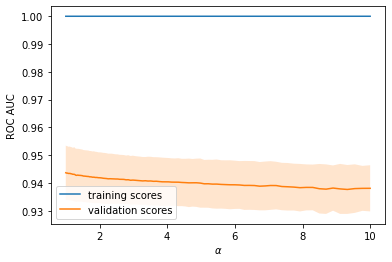

In [92]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.legend();

In [93]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(alpha=0.01):
    train_sizes = np.linspace(0.05, 1, 10)
    logit_pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(random_state=17, solver='liblinear', C=alpha))])
    N_train, val_train, val_test = learning_curve(logit_pipe,
                                                  X, Y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()

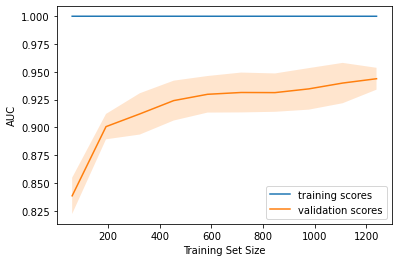

In [94]:
plot_learning_curve(alpha=0.95)